In [9]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np

In [19]:
class DataLoader:
    def __init__(self):
        self.train, self.valid, self.test = self.load_data()

    def load_data(self):
        """Load MNIST train, validation, and test data."""
        # For notebooks, use relative path to parent directory
        data_path = '../mnist.pkl'
        with open(data_path, 'rb') as f:
            train, valid, test = pickle.load(f, encoding='latin-1')
        return train, valid, test
    
    def get_data_information(self):
        """Return the shape of the datasets, their data types, unique labels and data range."""
        return {
            'train': (self.train[0].shape, self.train[1].shape),
            'train_data_type': type(self.train[0]),
            'valid': (self.valid[0].shape, self.valid[1].shape),
            'valid_data_type': type(self.valid[0]),
            'test': (self.test[0].shape, self.test[1].shape),
            'test_data_type': type(self.test[0]),
            'unique_labels': set(self.train[1]),
            'training_data_range': (self.train[0].min(), self.train[0].max())
        }
    
    def get_train_data(self):
        """Return training data and labels."""
        return self.train

    def get_valid_data(self):
        """Return validation data and labels."""
        return self.valid

    def get_test_data(self):
        """Return test data and labels."""
        return self.test
    
    def get_all_data(self):
        """Return all datasets."""
        return self.train, self.valid, self.test
    
    def print_data_summary(self):
        """Print a summary of the datasets."""
        info = self.get_data_information()
        print("Data Summary:")
        print(f"Training set: {info['train'][0]} samples, Labels: {info['train'][1]}")
        print(f"Validation set: {info['valid'][0]} samples, Labels: {info['valid'][1]}")
        print(f"Test set: {info['test'][0]} samples, Labels: {info['test'][1]}")
        print(f"Unique labels in training set: {info['unique_labels']}")
        print(f"Training data range: {info['training_data_range']}")
    
    def draw_sample(self, data, labels, index=None):
        """Draw a sample image from the dataset.
        
        Args:
            data: Image data array (samples, height, width) or (samples, pixels)
            labels: Label array
            index: Index of image to draw (random if None)
        """
        if index is None:
            index = np.random.randint(0, len(data))
        
        image = data[index]
        label = labels[index]
        
        # Reshape if flattened (784 pixels -> 28x28)
        if len(image.shape) == 1:
            image = image.reshape(28, 28)
        
        plt.figure(figsize=(6, 6))
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
        plt.show()

# Data example

Data Summary:
Training set: (50000, 784) samples, Labels: (50000,)
Validation set: (10000, 784) samples, Labels: (10000,)
Test set: (10000, 784) samples, Labels: (10000,)
Unique labels in training set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data range: (0.0, 0.99609375)


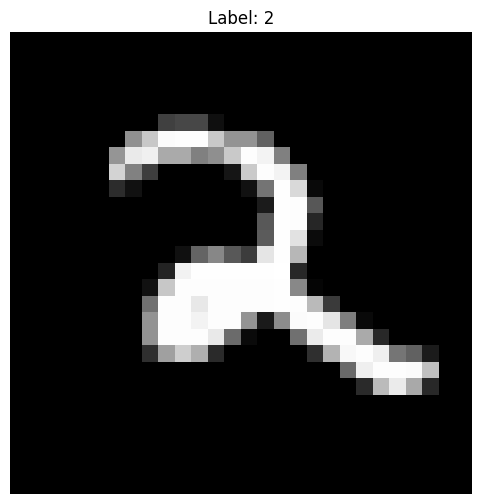

In [20]:
# Test the DataLoader
loader = DataLoader()
loader.print_data_summary()
train_data, train_labels = loader.get_train_data()
loader.draw_sample(train_data, train_labels)

In [21]:
class Data:
    """Data class for implementing autograd for np.ndarray operations."""

    def __init__(self, values: np.ndarray, parents=None, grad=False):
        self._data = values
        self._backward = lambda: None
        self._grad = grad
        self._num_grad = np.zeros_like(self._data)  # accumulated gradient
        self._parents = parents

    def __str__(self):
        return str(self._data)

    def __repr__(self):
        return f"grad={self._grad} data={str(self)}"

    def _match_shape(grad, shape):
        """Sum grad over broadcasted dims so it matches shape."""
        while len(grad.shape) > len(shape):
            grad = grad.sum(axis=0)
        for i, (g, s) in enumerate(zip(grad.shape, shape)):
            if s == 1 and g > 1:
                grad = grad.sum(axis=i, keepdims=True)
        return grad

    def __add__(self, other):
        if isinstance(other, Data):
            out = Data(self._data + other._data, parents=(self, other))
            def _backward():
                self._num_grad += Data._match_shape(out._num_grad, self._data.shape)
                other._num_grad += Data._match_shape(out._num_grad, other._data.shape)
            out._backward = _backward
            return out
        out = Data(self._data + other, parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(out._num_grad, self._data.shape)
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        if isinstance(other, Data):
            out = Data(self._data - other._data, parents=(self, other))
            def _backward():
                self._num_grad += Data._match_shape(out._num_grad, self._data.shape)
                other._num_grad += Data._match_shape(-out._num_grad, other._data.shape)
            out._backward = _backward
            return out
        out = Data(self._data - other, parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(out._num_grad, self._data.shape)
        out._backward = _backward
        return out

    def __rsub__(self, other):
        return -self + other

    def __mul__(self, other):
        if isinstance(other, Data):
            out = Data(self._data * other._data, parents=(self, other))
            def _backward():
                self._num_grad += Data._match_shape(out._num_grad * other._data, self._data.shape)
                other._num_grad += Data._match_shape(out._num_grad * self._data, other._data.shape)
            out._backward = _backward
            return out
        out = Data(self._data * other, parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(out._num_grad * other, self._data.shape)
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __matmul__(self, other):
        if isinstance(other, Data):
            out = Data(self._data @ other._data, parents=(self, other))
            def _backward():
                self._num_grad += out._num_grad @ other._data.T
                other._num_grad += self._data.T @ out._num_grad
            out._backward = _backward
            return out
        out = Data(self._data @ other, parents=(self,))
        def _backward():
            self._num_grad += out._num_grad @ other.T
        out._backward = _backward
        return out

    def __truediv__(self, other):
        if isinstance(other, Data):
            out = Data(self._data / other._data, parents=(self, other))
            def _backward():
                self._num_grad += Data._match_shape(out._num_grad / other._data, self._data.shape)
                other._num_grad += Data._match_shape(out._num_grad * (-self._data / (other._data ** 2)),
                                                     other._data.shape)
            out._backward = _backward
            return out
        out = Data(self._data / other, parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(out._num_grad / other, self._data.shape)
        out._backward = _backward
        return out

    def __rtruediv__(self, other):
        return other * Data(np.array([1.0])) / self

    def __neg__(self):
        out = Data(-self._data, parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(-out._num_grad, self._data.shape)
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supports int/float powers"
        out = Data(self._data ** other, parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(out._num_grad * other * self._data ** (other - 1),
                                                self._data.shape)
        out._backward = _backward
        return out

    # --- activations ---
    def exp(self):
        out = Data(np.exp(self._data), parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(np.exp(self._data) * out._num_grad, self._data.shape)
        out._backward = _backward
        return out

    def sigmoid(self):
        out = Data(1 / (1 + np.exp(-self._data)), parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(out._num_grad * (out._data * (1 - out._data)),
                                                self._data.shape)
        out._backward = _backward
        return out


    def backward(self):
        #Calculate gradient and if previusly calculated gradients exist, averages

        self._nodes = []
        visited = set()

        def sort(item):  # topological sorting
            if not item in visited:
                visited.add(item)
            if not item._parents:
                pass
            else:
                for parent in item._parents:
                    sort(parent)
            self._nodes.append(item)

        sort(self)
        self._num_grad = np.ones_like(self._data, dtype=np.float64)
        for item in reversed(self._nodes):
            item._backward()
        return None

    def step(self,step_size):
        for item in reversed(self._nodes):
            if item._grad:
                if item._data.shape[1]==1:
                    item._data-=step_size*np.mean(item._num_grad, axis=1).reshape(item._data.shape)
                else:
                    item._data-=step_size*item._num_grad
                item._num_grad=np.zeros_like(item._data)

    def mean(self):
        out = Data(np.mean(self._data), parents=(self,))
        def _backward():
            # d(mean)/dx = 1/N for each element
            self._num_grad += np.ones_like(self._data) / self._data.size * out._num_grad
        out._backward = _backward
        return out


class Layer:
    def __init__(self, input: int, output: int, a_function):
        self._weights = Data(np.random.normal(loc=0, scale=0.1, size=(output, input)), grad=True)
        self._bias = Data(np.random.normal(loc=0, scale=0.1, size=(output, 1)), grad=True)
        
        if a_function == 'sigmoid':
            self._activation = lambda x: x.sigmoid()
        elif a_function == None:
            self._activation = lambda x: x
        else:
            self._activation = a_function

    def forward(self, input: np.ndarray):
        a = self._weights @ input + self._bias
        return self._activation(a)

    def __str__(self):
        return f"Layer of {len(self._weights)} neurons"


class NeuralNetwork:
    def __init__(
        self,
        input_size: int,
        hidden_sizes: list,
        output_size: int,
        activation_function,
        final_activation=True,
    ):
        if not isinstance(activation_function, list):
            activation_function = [
                activation_function for _ in range(len(hidden_sizes) + 2)
            ]
        activation_function[0]=None
        sizes = [input_size] + hidden_sizes + [output_size]
        self._layers = []
        for i in range(len(sizes)-1):
            self._layers.append(Layer(sizes[i], sizes[i + 1], activation_function[i]))

    def forward(self, x):
        z = x.copy()
        for layer in self._layers:
            z=layer.forward(z)
        return z
        # """
        # X: input with shape (input_size, batch_size) ← mini-batch
        # Output: y_hat with shape (output_size, batch_size)
        # """
        # # 1) Add bias neuron to input layer: (input_size+1, batch_size)
        # Xb = self._append_bias_row(X)

        # # 2) Pre-activation of hidden layer: z1 = W1 · Xb
        # z1 = self.W1 @ Xb

        # # 3) Hidden layer activation: a1 = sigmoid(z1) → (hidden_size, batch_size)
        # a1 = self.sigmoid(z1)

        # # 4) Add bias neuron to a1: (hidden_size+1, batch_size)
        # a1b = self._append_bias_row(a1)

        # # 5) Pre-activation of output layer: z2 = W2 · a1b
        # z2 = self.W2 @ a1b

        # # 6) Output activation: a2 = sigmoid(z2) → (output_size, batch_size)
        # a2 = self.sigmoid(z2)

        # # Save for backpropagation
        # self.cache = {
        #     "X": X, "Xb": Xb,
        #     "z1": z1, "a1": a1, "a1b": a1b,
        #     "z2": z2, "a2": a2
        # }
        # return a2



In [22]:


class Trainer:

    def __init__(self,epochs,batch_size):
        data = loader.get_train_data()
        self._x_data = data[0]
        self._y_data = data[1]
        self._batch_size = batch_size
        self._epochs = epochs
        self._loss_list = []
        self._guess = []
        self._model=None


    def train(self,network,loss_function):
        self._loss_list = []
        self._guess = []
        self._model=network

        for epoch in range(self._epochs):
            loss, y_out = self._calculateLoss(self._batch_size,loss_function)
            loss.backward()
            step_size = self._calculateStepSize(loss,y_out)
            loss.step(step_size)

        return self._model

    def _calculateLoss(self,batch_size,loss_function):
        idx = np.random.choice(len(self._y_data), batch_size, replace=False)

        choosen_x = self._x_data[idx].T 

        y_out = self._model.forward(choosen_x)

        y_correct = np.zeros((y_out._data.shape[0],batch_size))

        preds = np.argmax(y_out._data,axis=0)
        correct = np.sum(preds == self._y_data[idx])
        self._guess.append(correct / batch_size)

        y_correct[self._y_data[idx],np.arange(batch_size)] = 1
        #loss = ((y_out - y_correct) **2).mean()           
        loss = loss_function(y_out,y_correct).mean()

        self._loss_list.append(np.linalg.norm(loss._data))

        return loss, y_out
    
    def _calculateStepSize(self,loss,y_out):
        #Calculate step size such that a(w+step*grad) < a(w) => a(w) - a(w+step*grad) > 0
        grad = loss._num_grad
        activation_func = self._model._layers[-1]._activation #Takes the final activation function, so might not work as well if different activation func for each layer
        nbr_step_test = 100
        step_difference = []

        for step_test in np.linspace(0.0001,0.1,nbr_step_test):
            w_old = activation_func(y_out)
            w_new = activation_func(y_out + step_test*grad)
            diff = w_old - w_new
            diff_norm = np.linalg.norm( diff._data )
            step_difference.append(diff_norm)
        max_diff = max(step_difference)
        index = step_difference.index(max_diff)
        
        return step_difference[index]
        

In [ ]:
class Trainer:
    def __init__(self, epochs, batch_size, patience=8, lr_factor=0.5):
        data = loader.get_train_data()
        self._x_data = data[0]
        self._y_data = data[1]
        self._batch_size = batch_size
        self._epochs = epochs
        self._loss_list = []
        self._guess = []
        self._model = None
        self._step_size = 0.1  # initial learning rate
        self._patience = patience
        self._lr_factor = lr_factor
        self._best_val_loss = float('inf')
        self._wait = 0

    def train(self, network):
        self._loss_list = []
        self._guess = []
        self._model = network
        val_data, val_labels = loader.get_valid_data()

        for epoch in range(self._epochs):
            loss, y_out = self._calculateLoss(self._batch_size)
            loss.backward()
            loss.step(self._step_size)
            # Validation loss
            val_loss = self._validation_loss(val_data, val_labels)
            self._loss_list.append(np.linalg.norm(loss._data))
            # Regulate learning rate
            self._step_size = self._calculateStepSize(loss, y_out)
            self._step_size = self.p_regulator(val_loss, self._step_size)
        return self._model

    def _calculateLoss(self, batch_size):
        idx = np.random.choice(len(self._y_data), batch_size, replace=False)
        choosen_x = self._x_data[idx].T
        y_out = self._model.forward(choosen_x)
        y_correct = np.zeros((y_out._data.shape[0], batch_size))
        preds = np.argmax(y_out._data, axis=0)
        correct = np.sum(preds == self._y_data[idx])
        self._guess.append(correct / batch_size)
        y_correct[self._y_data[idx], np.arange(batch_size)] = 1
        loss = ((y_out - y_correct) ** 2).mean()
        return loss, y_out
    
    def _calculateStepSize(self,loss,y_out):
        #Calculate step size such that a(w+step*grad) < a(w) => a(w) - a(w+step*grad) > 0
        grad = loss._num_grad
        activation_func = self._model._layers[-1]._activation #Takes the final activation function, so might not work as well if different activation func for each layer
        nbr_step_test = 100
        step_difference = []

        for step_test in np.linspace(0.0001,0.1,nbr_step_test):
            w_old = activation_func(y_out)
            w_new = activation_func(y_out + step_test*grad)
            diff = w_old - w_new
            diff_norm = np.linalg.norm( diff._data )
            step_difference.append(diff_norm)
            
        return max(step_difference)

    def _validation_loss(self, val_data, val_labels, batch_size=10):
        idx = np.random.choice(len(val_labels), batch_size, replace=False)
        val_x = val_data[idx].T
        y_out = self._model.forward(val_x)
        y_correct = np.zeros((y_out._data.shape[0], batch_size))
        y_correct[val_labels[idx], np.arange(batch_size)] = 1
        val_loss = ((y_out - y_correct) ** 2).mean()._data
        return val_loss

    def p_regulator(self, val_loss, step_size):
        if val_loss < self._best_val_loss:
            self._best_val_loss = val_loss
            self._wait = 0
        else:
            self._wait += 1
            if self._wait >= self._patience:
                step_size *= self._lr_factor
                self._wait = 0
        return step_size

Task 5

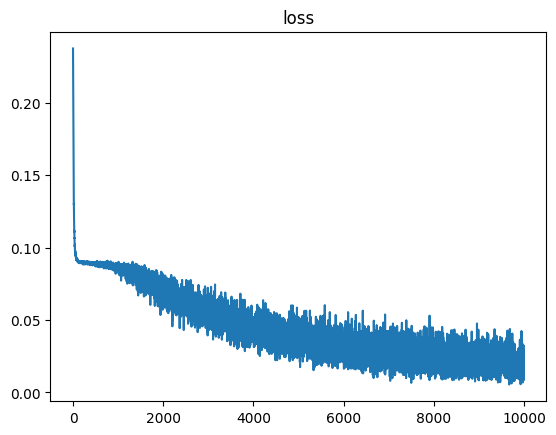

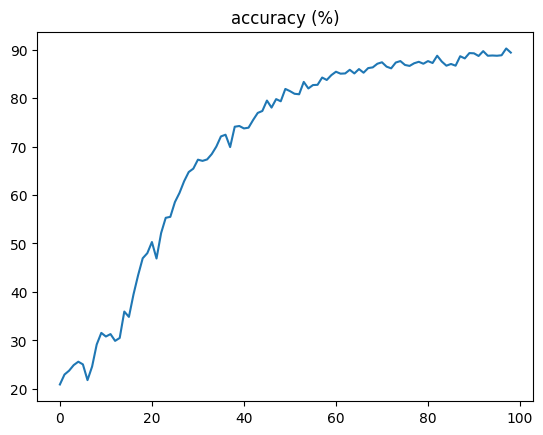

Final accuracy: 89.4 %


In [23]:

epochs = 10000 #10000
batch_size = 20 #64
input_size = 784
output_size = 10
hidden_size = [30]*2

nn = NeuralNetwork(input_size, hidden_size, output_size, "sigmoid")
                
tran = Trainer(epochs,batch_size)

loss_function = lambda y_out,y_correct: (y_out - y_correct) ** 2
nn = tran.train(nn,loss_function)

plt.plot([i for i in range(len(tran._loss_list))], tran._loss_list)
plt.title("loss")
plt.show() 
acc = []
for i in range(0, epochs-100, 100):
    acc.append(np.sum(tran._guess[i:i+100]))
plt.plot([i for i in range(len(acc))], acc)
plt.title("accuracy (%)")
plt.show()
print("Final accuracy:", acc[-1], "%")

## Bitwise representation

## ATTACK

In [ ]:
# === Test data (MNIST) ===
X_test, Y_test = loader.get_test_data()          # or: already have X_test, Y_test
X_test = X_test.astype(np.float32, copy=False)
if X_test.max() > 1.0:  # normalize to [0,1] if needed
    X_test /= 255.0

# === Minimal helpers ===
import numpy as np

# Force input to (D, B) to match the model
D = nn._layers[0]._weights._data.shape[1]  # e.g., 784 for MNIST
def as_DB(X):
    """Return X as (D,B). Only handles 1D/2D MNIST-style (flat)."""
    X = np.asarray(X, dtype=np.float32)
    if X.ndim == 1:
        return X.reshape(D, 1)
    return X if X.shape[0] == D else X.T

def to_indices(Y):
    """One-hot (C,B) -> indices (B,) or pass-through if already indices."""
    Y = np.asarray(Y)
    return np.argmax(Y, axis=0) if Y.ndim == 2 else Y

def predict_idx(M, X):
    """Argmax over classes."""
    X_db = as_DB(X)
    out = M.forward(Data(X_db))              # Data with shape (C,B)
    return np.argmax(out._data, axis=0)

NameError: name 'loader' is not defined

In [ ]:
from adapters_autograd import build_grad_x_fn_autograd
from attack_fgsm import fgsm_attack

# Build dL/dx bridge (square loss), no change to teammates' code
grad_x_fn = build_grad_x_fn_autograd(nn, Data)

# Craft adversarial examples (untargeted)
eps = 0.02
x_adv = fgsm_attack(
    as_DB(X_test),     # keep shapes consistent
    Y_test,
    epsilon=eps,
    grad_x_fn=grad_x_fn,
    clip_min=0.0, clip_max=1.0,
    targeted=False
)


In [ ]:
y_true_idx = to_indices(Y_test)
acc_clean = (predict_idx(nn, X_test) == y_true_idx).mean()
acc_adv   = (predict_idx(nn, x_adv)  == y_true_idx).mean()
print(f"ε={eps} | Accuracy (clean): {acc_clean*100:.2f}%  | Accuracy (adv): {acc_adv*100:.2f}%")

# Optional: quick sweep
eps_list = [0.0, 0.005, 0.01, 0.02, 0.03]
print("\nFGSM sweep:")
for e in eps_list:
    x_adv_e = fgsm_attack(as_DB(X_test), Y_test, e, grad_x_fn,
                          clip_min=0.0, clip_max=1.0, targeted=False)
    adv_acc = (predict_idx(nn, x_adv_e) == y_true_idx).mean()
    print(f"  eps={e:>5}: clean={acc_clean*100:6.2f}%  adv={adv_acc*100:6.2f}%")
